# Fully Connected Network of Cifar 10 Images

## Tuonti ja datan lataus

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers, regularizers

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import cifar10

In [ ]:
from keras import backend as K
print(K.backend())

tensorflow


Ladataan Cifar 10 -setin data ja tallenetaan koulutusdata ja testidata erillisiin muuttujiin. (X: kuvat ja y: luokat)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Datan esikäsittely

Vaihdetaan pixelien arvot 0–255 → 0–1

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

Värikanavien keskiarvojen ja -hajontojen laskeminen normalisointia varten.

In [ ]:
mean = np.mean(x_train, axis=(0, 1, 2))
std  = np.std(x_train, axis=(0, 1, 2))
print("mean: ", mean)
print("std: ", std)

mean:  [0.4914009  0.48215896 0.4465308 ]
std:  [0.24703279 0.24348423 0.26158753]


Normalisointi, jotta jokaisen kanavan arvot ovat varmasti samassa mittakaavassa. Tästä seuraa vakaampi oppiminen mallille.

In [ ]:
mean = tf.constant(mean, dtype=tf.float32)
std  = tf.constant(std, dtype=tf.float32)

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

## Mallin rakentaminen

Mallille annetaan kuva, jonka koko on 32×32 pixeliä ja kolme värikanavaa (R, G, B). Tätä ennen kuvat on standardoitu, jotta pikseliarvot ovat nollan ympärillä.

In [ ]:
wd = 1e-4  #weight decay
lr= 1e-3   #learning rate
drop = 0.5 #dropout rate

inputs = keras.Input(shape=(32, 32, 3))

Datan augmentointia: satunnaisesti kääntää (vaakasuunnassa) ja siirtää kuvaa (vaaka- ja pystysuunnassa). Näillä pyrimme estämään mallia oppimasta valheellisia piirteitä (esim. auton etuosa olisi aina vasemmalla tai koira olisi kuvan keskellä). Mallin on nyt mahdollista oppia tunnistamaan kohteet riippumatta niiden suunnasta ja sijainnista kuvissa.

In [ ]:
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomTranslation(0.1, 0.1)(x)

Flatten: (32, 32, 3) → (3072). Keras litistää tuon 3D-muodon (korkeus, leveys, kanavat) yhdeksi pitkäksi vektoriksi.

Dense: Ensimmäinen varsinainen oppiva kerros. Jokainen 2048 neuroni on yhteydessä kaikkiin 3072 syötteeseen. Painoihin on lisätty L2-regularisointi, joka estää yksittäisiä painoja kasvamasta liian suuriksi. Bias-termi on otettu pois käytöstä, koska seuraava kerros hoitaa sitten sen kompensoinnin.

BatchNormalization: Normalisoi aktivaatioarvot jokaiselta neuronilta.

Activation (ReLU): Negatiiviset arvot asetetaan nolliksi ja jättää positiiviset arvot sitten ennalleen.

Dropout: Sammuttaa randomisti osan neuroneista jokaisella koulutuskierroksella.

In [ ]:
x = layers.Flatten()(x)
x = layers.Dense(2048, use_bias=False,
                 kernel_regularizer=regularizers.l2(wd))(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Dropout(drop)(x)

Toistetaan sama rakenne, mutta pienemmällä neuronimäärällä (1024 neuronia).

In [ ]:
x = layers.Dense(1024, use_bias=False,
                 kernel_regularizer=regularizers.l2(wd))(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Dropout(drop)(x)

Vielä pienempi tiivistysvaihe (512 neuronia), jossa tieto tiivistyy kohti luokituspäätöstä.

In [ ]:
x = layers.Dense(512, use_bias=False,
                 kernel_regularizer=regularizers.l2(wd))(x)
x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
x = layers.Dropout(0.4)(x)


Output-kerros, joka tuottaa 10 arvoa (yhden jokaiselle luokalle). Softmax-aktivaatio muuttaa arvot todennäköisyyksiksi (summattuna 1).

In [ ]:
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs, name="cifar10_fcn")

Mallin verkko näyttää seuraavalta

In [ ]:
model.summary()

Model: "cifar10_fcn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     6,291,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,932,362 (34.07 MB)

 Trainable params: 8,925,194 (34.05 MB)

 Non-trainable params: 7,168 (28.00 KB)

Tästä nähdään että malli muodostuu useista kerroksista kuten syöteestä, augmentoinneista, muotoilusta, denseistä, normalisoinneista, aktivoinneista ja dropouteista.

Alunperin mallin rakenne oli paljon yksinkertaisempi sisältäen vain pakolliset kerrokset (Input, Flatten, pari Denseä, ReLUa ja softmaxia) isoilla neuronimäärillä, mutta nopeasti huomasimme että näin oli mahdollista päästä parhaimmillaan 30% tarkkuuteen lähes 20-30 minuutin koulutusajalla. Tutkiskelun jälkeen löysimme tapoja, joilla parantaa tarkkuutta, sekä nopeuttaa koulutusta, joista muodostui loppujen lopuksi yläpuolelta löytyvä rakenne.

## Mallin konfigurointi

Jokaisella kuvalla on yksi oikea luokka, jonka takia häviöfunktiona toimii SparseCategoricalCrossentropy. Tämän valinnan ansiosta ei myöskään tarvitse datan esikäsittelyssä one-hot-encodeta dataa. Alunperin optimizerina oli Adam, mutta vaihdettuamme AdamW:hen sillä se paranti mallin yleistämiskykyä ja vakautti oppimista.

In [ ]:
optimizer = keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

## Mallin kouluttaminen

ReduceLROnPlateau: Val_accuracy pitää parantua vähintää joka viides epoch tai oppimisnopeus (lr) puolitetaan.

EarlyStopping: Koulutus loppuu ennenaikaisesti, jos malli ei parane 15 epochin aikana. Malli myös palauttaa aiemmat arvot, mikäli pitempi oppiminen johtaa huonompiin tuloksiin.

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5,
                                      patience=5, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15,
                                  restore_best_weights=True),
]

Mallia koulutettiin käymällä koko aineisto läpi 100 kertaa (100 epochia) ja päivittämällä painoarvoja 256 esimerkin välein (batch size 256). 90 % datasta käytettiin koulutukseen ja 10 % validointiin. Callbackit (ReduceLROnPlateau, EarlyStopping) säätivät oppimisnopeutta ja pysäyttivät koulutuksen tarvittaessa. Koulutuksen kokonaisaika mitattiin ja tallennettiin muuttujaan train_time.

In [ ]:
batch_size = 256
epochs = 100

start_time = time.time()

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=True,
)

train_time = time.time() - start_time

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2945 - loss: 2.4999 - val_accuracy: 0.4050 - val_loss: 2.1449 - learning_rate: 0.0010
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3706 - loss: 2.1899 - val_accuracy: 0.4462 - val_loss: 1.9556 - learning_rate: 0.0010
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4068 - loss: 2.0572 - val_accuracy: 0.4660 - val_loss: 1.8632 - learning_rate: 0.0010
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4205 - loss: 1.9806 - val_accuracy: 0.4858 - val_loss: 1.7934 - learning_rate: 0.0010
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4350 - loss: 1.9210 - val_accuracy: 0.4960 - val_loss: 1.7486 - learning_rate: 0.0010
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4412 - loss: 1.8886 - val_accuracy: 0.4980 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4444 - l

## Mallin arviointi

Luodaan kaksi kaaviota näyttämään mallin oppimiskäyrä ja tarkkuuskäyrä mallin koulutuksesta saadulla datalla.

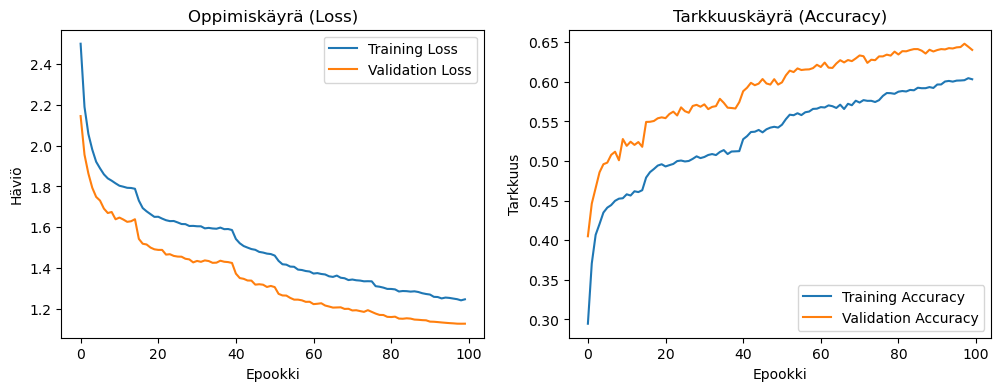

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Oppimiskäyrä (Loss)')
plt.xlabel('Epookki')
plt.ylabel('Häviö')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tarkkuuskäyrä (Accuracy)')
plt.xlabel('Epookki')
plt.ylabel('Tarkkuus')
plt.legend()
plt.show()

Kaavioista voidaan huomata, että mitä useampia epoch-kierroksia mallin koulutuksessa käytettiin, sitä parempia tuloksia saavutettiin. Tämä kuitenkin lisää laskennallista kuormitusta, sillä epochien määrän kasvattaminen ja batch-ko’on pienentäminen vaativat enemmän resursseja. Heikommalla laitteistolla koulutus voi tällöin kestää useita kymmeniä minuutteja.

Seuraavaksi testataan mallin lopullinen tarkkuus ja virheet testidatalla, tulostetaan koulutukseen kuluneen ajan sekä mallin koon ja käytettyjen epochien määrän.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=256, verbose=2)
print(f'\nTest loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.2f}')
print("Training time (s):", train_time)
print("Parameters:", model.count_params())
print("Epochs:", epochs)

40/40 - 0s - 7ms/step - accuracy: 0.6370 - loss: 1.1535

Test loss: 1.1535
Test accuracy: 0.64
Training time (s): 346.50748109817505
Parameters: 8932362
Epochs: 100


Viimeisenä voidaan tarkastella vielä graafisesti mallin ennusteita. Vasemmalla näytetään alkuperäinen testikuva, joka palautetaan näkyvälle värialueelle poistamalla normalisointi (img = x * std + mean). Oikealla piirretään pylväsdiagrammi, joka esittää mallin antamat todennäköisyydet kaikille 10 CIFAR-10-luokalle. Kuvan otsikossa näkyvät mallin ennustama ja todellinen luokka (Predicted ja True).

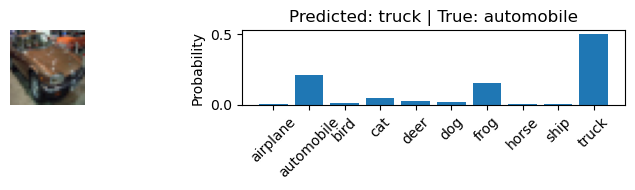

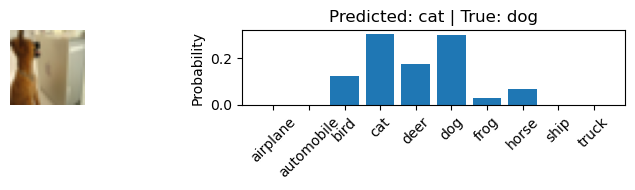

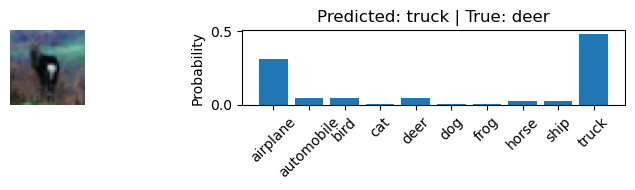

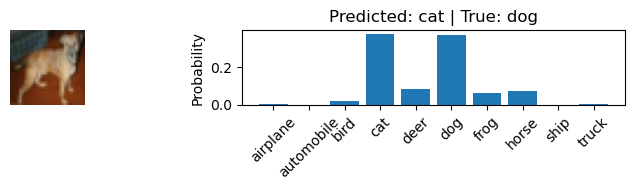

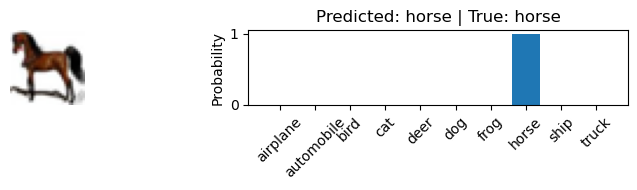

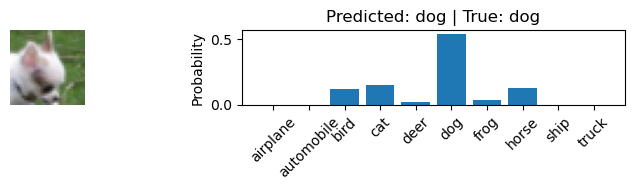

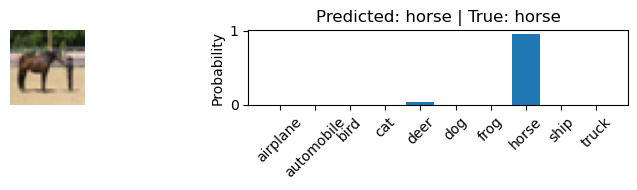

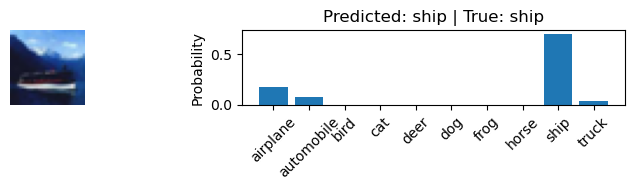

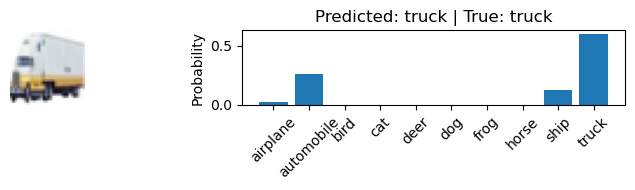

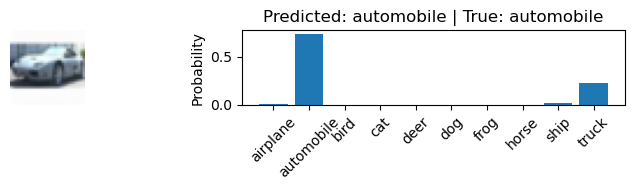

In [ ]:
x = x_test
y_pred = model(x, training=False)
start = 2000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Kuva — palautetaan normalisointi
    img = x[start + k] * std + mean

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    # Ennusteet
    plt.subplot(1, 2, 2)
    probs = y_pred[start + k].numpy().flatten()
    plt.bar(np.arange(10), probs)
    plt.xticks(np.arange(10), class_names, rotation=45)

    pred_label = class_names[np.argmax(probs)]
    true_label = class_names[y_test.flatten()[start + k]]

    plt.ylabel("Probability")
    plt.title(f"Predicted: {pred_label} | True: {true_label}")

    plt.tight_layout()
    plt.show()


Tuloksista huomaamme, että modelli helposti sekoitti visuaalisesti samankaltaiset luokat (esim. cat ↔ dog, truck ↔ automobile). Kuitenkin 62% (+-2) test accuracy on paljon parempi kuin täysin arvailemalla heitetyt luokittelut (10 luokkaa joten - 10% todennäköisyys osua oikeaan puhtaalla arvauksella), joten sen kannalta tulos on melko hyvä.